In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from cicTools import *
from scipy import spatial
import random 
import readgadget
import readfof
import redshift_space_library as RSL


In [2]:

# r = 7000
# lbox = 205000
# V = lbox**3

###########################
# READ DATA
###########################
snapdir = '/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/fiducial/0/' #folder hosting the catalogue
snapnum = 4   
# get the name of the corresponding snapshot
snapshot = '/home/fdavilakurban/mnt/clemente/quijote/Snapshots/fiducial/0/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

print('BoxSize = %.3f Mpc/h'%BoxSize)
print('Number of particles in the snapshot:',Nall)
print('Omega_m = %.3f'%Omega_m)
print('Omega_l = %.3f'%Omega_l)
print('h = %.3f'%h)
print('redshift = %.1f'%redshift)

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles

print(pos_h[:3])

BoxSize = 1000.000 Mpc/h
Number of particles in the snapshot: [        0 134217728         0         0         0         0]
Omega_m = 0.318
Omega_l = 0.682
h = 0.671
redshift = 0.0
[[184.29701 779.9311  774.9886 ]
 [411.87167 388.3982  873.5964 ]
 [612.3167  642.5959  501.4779 ]]


In [15]:

ntot = len(pos_h)

#pos = np.column_stack((gxs['x'],gxs['y'],gxs['z']))
#pos = pos[:round(len(pos)*.0015)]
#ntot = len(pos)
#print()

V = BoxSize**3
msep = (V/ntot)**(1/3)
wsradius = (3*V/(4*np.pi*ntot))**(1/3)
r = float(int(msep))
r=8

print('N_tot =',ntot)
print('Mean interparticle distance:',msep)
print('Wigner-Seitz radius:',wsradius)
print('Testing radius:',r)


N_tot = 406660
Mean interparticle distance: 13.497588423092239
Wigner-Seitz radius: 8.37323560422333
Testing radius: 8


In [16]:
newpos = perrep_array(pos_h,BoxSize,r)
print(pos_h,newpos)
tree = spatial.cKDTree(newpos)

[[184.29701  779.9311   774.9886  ]
 [411.87167  388.3982   873.5964  ]
 [612.3167   642.5959   501.4779  ]
 ...
 [996.83923  925.3357   892.4293  ]
 [  7.811731 918.2273   971.05237 ]
 [  3.4588   961.9621   936.16876 ]] [[ 184.29701    779.9311     774.9886   ]
 [ 411.87167    388.3982     873.5964   ]
 [ 612.3167     642.5959     501.4779   ]
 ...
 [ 226.59511     -7.4454956 1002.4544   ]
 [ 875.8528      -7.1852417 1006.2256   ]
 [ 819.785       -1.3670044 1000.57117  ]]


In [17]:

ni, nf, nbin = 10000, 100000, 4
ns = np.geomspace(ni, nf, nbin).astype(int)

P0 = np.zeros(len(ns))
N_mean = np.zeros(len(ns))
xi_mean = np.zeros(len(ns))
chi = np.zeros(len(ns))
NXi = np.zeros(len(ns))
chi_std = np.zeros(len(ns))
NXi_std = np.zeros(len(ns))
P0_std = np.zeros(len(ns))
N_mean_std = np.zeros(len(ns))
xi_mean_std = np.zeros(len(ns))

for i,n in enumerate(ns):
    #chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i] = cic_stats(ran_tree, n, r, lbox)
    chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i], \
            chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i] = cic_stats_jk(tree, n, r, BoxSize, jkbins=3)



In [7]:

namefile = f'../data/stability_test_{ni,nf,nbin}.npz'

np.savez(namefile,chi, NXi, P0, N_mean, xi_mean, \
    chi_std, NXi_std, P0_std, N_mean_std,xi_mean_std)
print(f'Created {namefile}')

Created ../data/stability_test_(1000, 100000, 5).npz


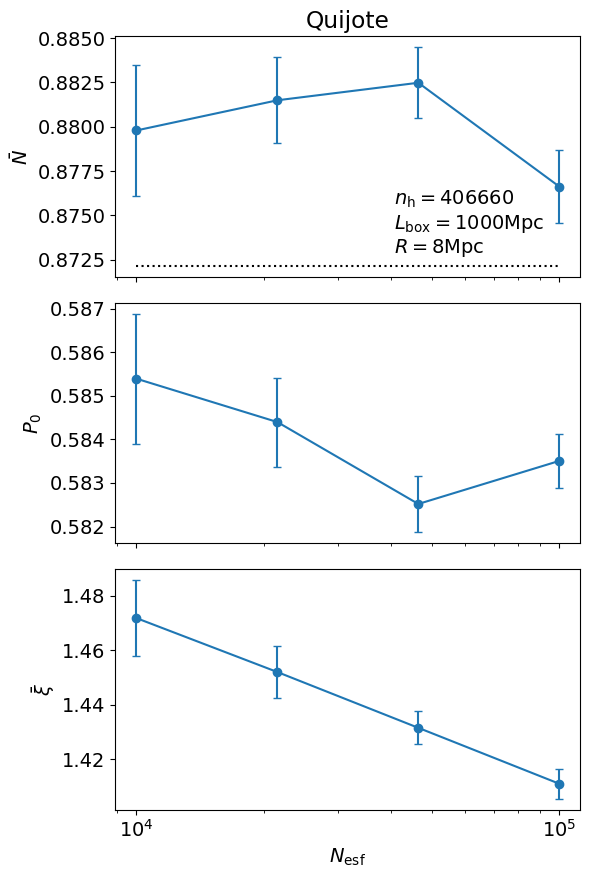

In [18]:

#%%
#
#Estos son los plots con JK
#
# r = 800
# lbox = 205000
# V = lbox**3

fig = plt.figure(figsize=(6,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.get_shared_x_axes().join(ax1, ax2, ax3)
plt.rcParams['font.size'] = 14

"""
Nmean
"""
N_mean_analytical = len(pos_h)*(4*np.pi*r**3/3)/(BoxSize)**3
ax1.hlines(N_mean_analytical,np.min(ns),np.max(ns),ls=':',color='k')
ax1.errorbar(ns,N_mean,yerr=N_mean_std,marker='o',capsize=3)
#ax1.plot(ns,N_mean)

ax1.text(.6,.3,r'$n_\mathrm{h}=$'+f'{len(pos_h)}', transform=ax1.transAxes)
ax1.text(.6,.1,r'$R=$'+f'{r}Mpc', transform=ax1.transAxes)
ax1.text(.6,.2,r'$L_\mathrm{box}=1000$Mpc', transform=ax1.transAxes)

ax1.set_ylabel(r'$\bar{N}$')
ax1.set_xscale('log')

"""
P0
"""
ax2.errorbar(ns,P0,yerr=P0_std,marker='o',capsize=3)

ax2.set_ylabel(r'$P_0$')
ax2.set_xscale('log')

"""
Xi_mean
"""
ax3.errorbar(ns,xi_mean,yerr=xi_mean_std,marker='o',capsize=3)

ax3.set_xlabel(r'$N_\mathrm{esf}$')
ax3.set_ylabel(r'$\bar{\xi}$')
ax3.set_xscale('log')

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_title('Quijote')
plt.tight_layout()
#plt.savefig('../plots/stability_tng300-1_jk.png')
plt.show()

# %%
